In [54]:
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pickle as pkl

In [55]:
mpl.rc('font',**{'family':'serif','serif':['Times New Roman']})
mpl.rc('font',**{'size':18})
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')

In [56]:
from GenomicTools.tools import *
from GenomicTools.tandem_duplications import *
from GenomicTools.synteny import *
from GenomicTools.dot_plots import *
from GenomicTools.permutations import *

# Dot plot, nanosynteny, and microsynteny

## Load data

In [57]:
spA, spB, dot_plot, dot_plot_labels = load_dot_plot('Homo_sapiens-Mus_musculus-dotplot.csv.gz')
spA, species_data_A, species_data_labels_A, chrom_info_A = load_species_data('Homo_sapiens_species_data.csv.gz')
spB, species_data_B, species_data_labels_B, chrom_info_B = load_species_data('Mus_musculus_species_data.csv.gz')

In [58]:
rho, N_A, N_B = calculate_density(dot_plot,chrom_info_A,chrom_info_B)
kmin = k_min(.05, rho, N_A, N_B)

In [59]:
if os.path.isfile('Homo_sapiens-Mus_musculus_synteny_block_results.pkl'):
    nano_blocks, micro_blocks, nblocks_with_maxdist, synteny_blocks_with_maxdist, synteny_coverage_with_maxdist = pkl.load(open('Homo_sapiens-Mus_musculus_synteny_block_results.pkl','rb'))
if os.path.isfile('Homo_sapiens-Mus_musculus_permutation_results.pkl'):
    pearson_with_perm, permutation_block_matrix = pkl.load(open('Homo_sapiens-Mus_musculus_permutation_results.pkl','rb'))
    permuted_dot_plots = {}
    for maxdist in range(0,31,3):
        perm_spA, perm_spB, perm_dot_plot, perm_labels = load_dot_plot('Homo_sapiens-Mus_musculus-permuted_dotplot_%i_swaps.csv.gz'%maxdist)
        permuted_dot_plots[maxdist] = perm_dot_plot

## Dot plot

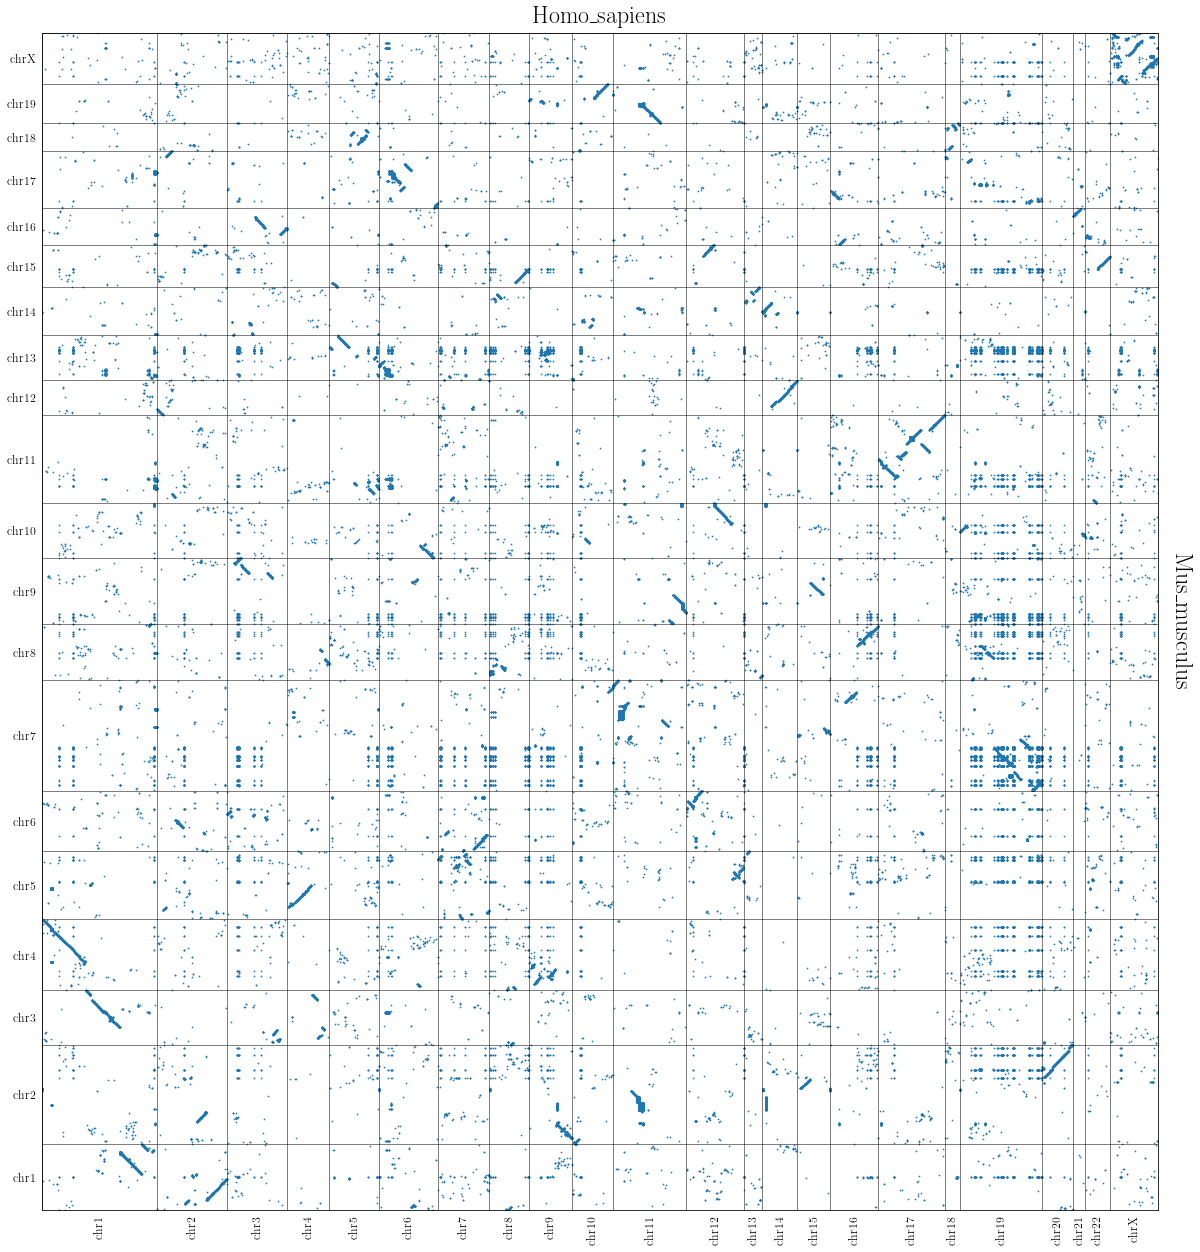

In [37]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,label1=spA,label2=spB)

## Nanosynteny

In [10]:
params = {}
params['dot_maxdist'] = 1
params['block_minsize'] = 2
params['dist_cutoff'] = 1
params['return_absolute_blocks'] = True

if 'nano_blocks' not in vars():
    nano_blocks = run_synteny_identification(dot_plot,species_data_A,species_data_B,chrom_info_A,chrom_info_B,params)

In [11]:
h_nano = np.unique([b.shape[0] for b in nano_blocks],return_counts=True)

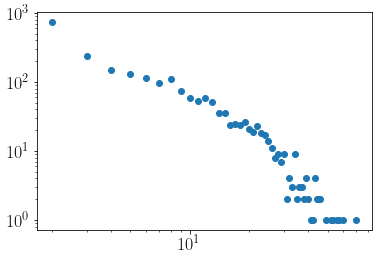

In [38]:
plt.scatter(h_nano[0],h_nano[1])
plt.xscale('log')
plt.yscale('log')

## Microsynteny

In [13]:
params = {}
params['dot_maxdist'] = 3
params['block_minsize'] = kmin
params['dist_cutoff'] = 30

if 'micro_blocks' not in vars():
    micro_blocks = run_synteny_identification(dot_plot,species_data_A,species_data_B,chrom_info_A,chrom_info_B,params)

In [212]:
h_micro = np.unique([b.shape[0] for b in micro_blocks],return_counts=True)

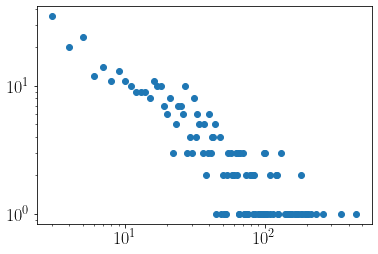

In [213]:
plt.scatter(h_micro[0],h_micro[1])
plt.xscale('log')
plt.yscale('log')

## Dot plot with microsynteny

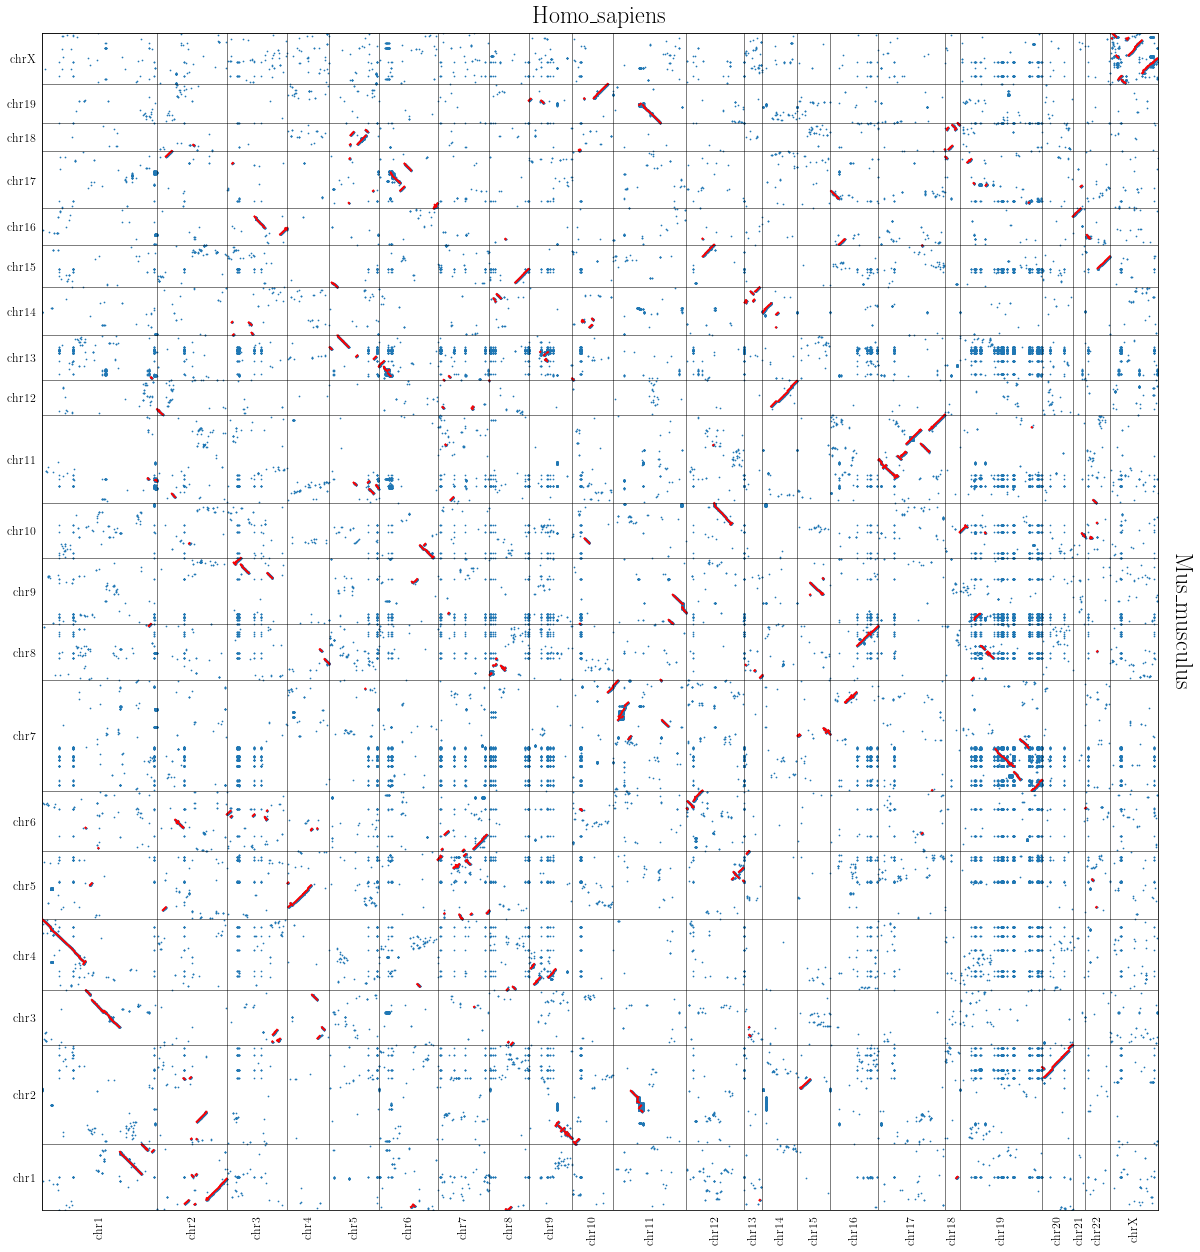

In [214]:
make_dot_plot_figure(dot_plot,chrom_info_A,chrom_info_B,synteny_blocks=micro_blocks,label1=spA,label2=spB)

# Statistical significance of nanosynteny

In [60]:
params = {}
params['dot_maxdist'] = 1
params['block_minsize'] = 2
params['dist_cutoff'] = 1
params['return_absolute_blocks'] = True

if ('permuted_dot_plots' not in vars()) or ('pearson_with_perm' not in vars()) or ('permutation_block_matrix' not in vars()):
    homology_matrix = convert_dot_plot_to_homology_matrix(dot_plot, chrom_info_A, chrom_info_B)
    permuted_dot_plots = {}
    pearson_with_perm = []
    permutation_block_matrix = np.zeros([11,11])
    for nk, kperms in enumerate(range(0,31,3)):
        perm_A, perm_B = generate_permutations(homology_matrix,kperms)
        permuted_homology_matrix, permuted_species_data_A, permuted_species_data_B, pearson = permute_homology_matrix(homology_matrix,species_data_A,species_data_B,perm_A,perm_B)
        permuted_dot_plot = convert_homology_matrix_to_dot_plot(permuted_homology_matrix)
        permuted_dot_plots[kperms] = np.copy(permuted_dot_plot)
        permuted_blocks = run_synteny_identification(permuted_dot_plot,permuted_species_data_A,permuted_species_data_B,chrom_info_A,chrom_info_B,params)
        h_perm = np.unique([b.shape[0] for b in permuted_blocks],return_counts=True)
        h_perm_size = h_perm[0][h_perm[0] < 11]
        h_perm_count = h_perm[1][h_perm[0] < 11]
        print(nk,kperms,h_perm_size,h_perm_count)
        permutation_block_matrix[nk,h_perm_size] = h_perm_count
        pearson_with_perm.append(pearson)
    pearson_with_perm = np.vstack(pearson_with_perm)

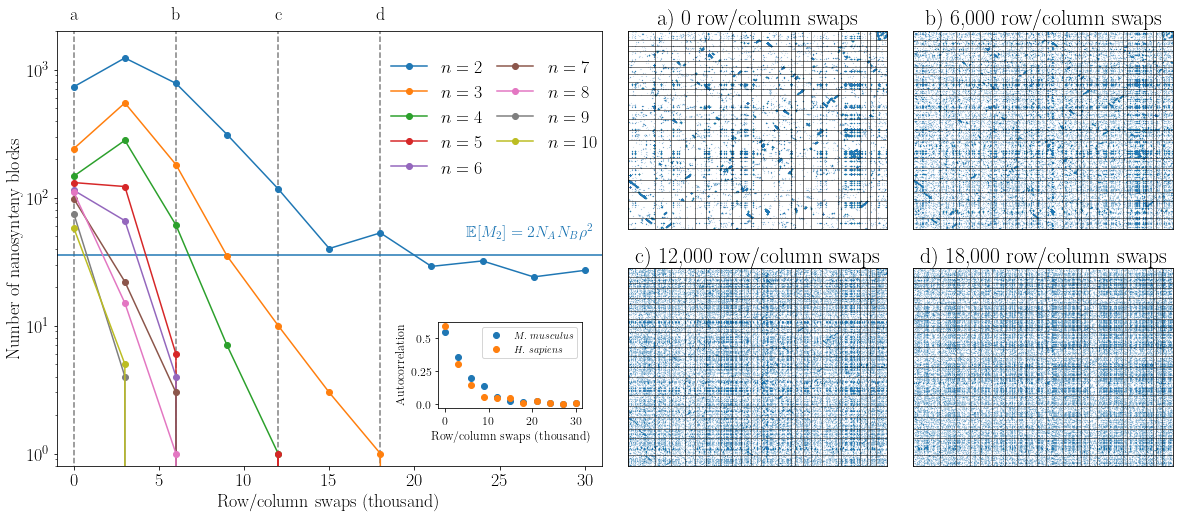

In [62]:
f = plt.figure(figsize=(20,8))
gs = plt.GridSpec(2, 4, figure=f)

ax1 = f.add_subplot(gs[:, :2])
for n in range(2,11):
    ax1.plot(np.arange(0,31,3),permutation_block_matrix[:,n],'-o',label=r'$n=%i$'%n)
ax1.plot([-2,32],[2*N_A*N_B*rho**2,2*N_A*N_B*rho**2],c='C0',zorder=-5)
ax1.legend(loc=(.6,.65),ncol=2,frameon=False,columnspacing=0.8)
ax1.set_yscale('log')
ax1.set_xlabel(r'Row/column swaps (thousand)')
ax1.set_ylabel(r'Number of nanosynteny blocks')
ax1.text(23,50,r'$\mathbb{E}[M_{2}]=2N_{A}N_{B}\rho^{2}$',fontsize=16,c='C0')
ax1.set_xlim(-1,31)
ax1.set_ylim(.8,2e3)
ax1.plot([0,0],[.1,1e4],'--',c='k',alpha=.5,zorder=-10)
ax1.text(0,2.5e3,r'a',horizontalalignment='center')
ax1.plot([6,6],[.1,1e4],'--',c='k',alpha=.5,zorder=-10)
ax1.text(6,2.5e3,r'b',horizontalalignment='center')
ax1.plot([12,12],[.1,1e4],'--',c='k',alpha=.5,zorder=-10)
ax1.text(12,2.5e3,r'c',horizontalalignment='center')
ax1.plot([18,18],[.1,1e4],'--',c='k',alpha=.5,zorder=-10)
ax1.text(18,2.5e3,r'd',horizontalalignment='center')

ax_inset = f.add_axes([.39,.225,.1,.15])
ax_inset.scatter(np.arange(0,31,3),pearson_with_perm[:,2],label=r'$M.~musculus$')
ax_inset.scatter(np.arange(0,31,3),pearson_with_perm[:,3],label=r'$H.~sapiens$')
ax_inset.set_xlabel(r'Row/column swaps (thousand)',fontsize=12)
ax_inset.set_ylabel(r'Autocorrelation',fontsize=12)
ax_inset.set_xticks([0,10,20,30])
ax_inset.set_xticklabels(['0','10','20','30'],fontsize=12)
ax_inset.set_yticks([0,.25,.5])
ax_inset.set_yticklabels(['0.0','0.25','0.5'],fontsize=12)
ax_inset.legend(frameon=True,fontsize=10)

ax2 = f.add_subplot(gs[0, 2])
make_dot_plot_figure(permuted_dot_plots[0],chrom_info_A,chrom_info_B,ax=ax2,dot_size=.005,chrom_labels_A=23*[''],chrom_labels_B=20*[''])
ax2.set_title(r'a) 0 row/column swaps')

ax3 = f.add_subplot(gs[0, 3])
make_dot_plot_figure(permuted_dot_plots[6],chrom_info_A,chrom_info_B,ax=ax3,dot_size=.005,chrom_labels_A=23*[''],chrom_labels_B=20*[''])
ax3.set_title(r'b) 6,000 row/column swaps')

ax4 = f.add_subplot(gs[1, 2])
make_dot_plot_figure(permuted_dot_plots[12],chrom_info_A,chrom_info_B,ax=ax4,dot_size=.005,chrom_labels_A=23*[''],chrom_labels_B=20*[''])
ax4.set_title(r'c) 12,000 row/column swaps')

ax5 = f.add_subplot(gs[1, 3])
make_dot_plot_figure(permuted_dot_plots[18],chrom_info_A,chrom_info_B,ax=ax5,dot_size=.005,chrom_labels_A=23*[''],chrom_labels_B=20*[''])
ax5.set_title(r'd) 18,000 row/column swaps')

f.subplots_adjust(wspace=.1)

#plt.savefig('permutation_test.png',dpi=300,bbox_inches='tight',facecolor='w')

# Saving results - run this cell after all others are finished

In [243]:
if not os.path.isfile('Homo_sapiens-Mus_musculus_synteny_block_results.pkl'):
    pkl.dump([nano_blocks, micro_blocks, nblocks_with_maxdist,synteny_blocks_with_maxdist, synteny_coverage_with_maxdist],open('Homo_sapiens-Mus_musculus_synteny_block_results.pkl','wb'))
if not os.path.isfile('Homo_sapiens-Mus_musculus_permutation_results.pkl'):
    pkl.dump([pearson_with_perm, permutation_block_matrix],open('Homo_sapiens-Mus_musculus_permutation_results.pkl','wb'))
    for maxdist in permuted_dot_plots.keys():
        save_dot_plot('Homo_sapiens-Mus_musculus-permuted_dotplot_%i_swaps.csv'%maxdist,spA,spB,permuted_dot_plots[maxdist],gzip_file=True)